# Process the images and build masks

In [7]:
#importations

import os
import SimpleITK as sitk
import numpy as np
import radiomics

from skimage import io as skio
from skimage import img_as_ubyte
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from radiomics import featureextractor, getFeatureClasses
from radiomics import glcm

import cv2


In [8]:
#functions definition

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

#Fonction qui calcule la moyenne des erreurs au carré
def mse(y_true,y_pred):
   n = len(y_true)
   mse = np.linalg.norm(y_true - y_pred)**2
   return mse/n


def flou(image, kernel_size=3):
    """
    Apply a custom random blur to an image.

    :param image: The input image (NumPy array).
    :param kernel_size: The size of the custom blur kernel (odd number).
    :return: The blurred image.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    kernel = np.random.rand(kernel_size, kernel_size)  # Random coefficients in the kernel
    kernel /= kernel.sum()  # Normalize the kernel to ensure the result is not too bright

    blurred_image = cv2.filter2D(image, -1, kernel)
    return blurred_image

In [9]:
#mask functions:

def crop(im):
  '''
  fonction qui rogne l'image en une image carré.
  '''
  n,p = im.shape
  L = min(n,p)
  return im[int((n-L)/2):int((n+L)/2), int((p-L)/2):int((p+L)/2)]


def circular_mask(im,R):
  '''
  Fonction qui genere un mask circulaire
  '''
  n,p = im.shape
  mask = np.zeros((n,p))

  O = np.array([int(n/2), int(p/2)])
  #R = 90    #réglé emiriquement

  for i in range(n):
    for j in range(p):
      if ( (np.linalg.norm(np.array([i,j]) - O) < R)):
        mask[i][j] = 1
  return mask

def triangle_mask(im, side_length):
    '''
    Fonction qui genere un mask triangulaire
    '''
    h, l = im.shape
    image = np.zeros((h, l), dtype=np.uint8)
    half_side = side_length / 2
    x1 = int((l - side_length) / 2)
    x2 = int((l + side_length) / 2)
    y1 = int((h + (side_length * np.sqrt(3) / 2)) / 2)
    y2 = int((h + (side_length * np.sqrt(3) / 2)) / 2 - side_length * np.sqrt(3) / 2)

    pts = np.array([[x1, y1], [x2, y1], [l // 2, y2]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.fillPoly(image, [pts], 1)

    return image




In [50]:
image = 'IMA201_Medical_images/Thyroid_US/US_thyroid_image_004.png'
mask =  'IMA201_Medical_images/Thyroid_US/US_thyroid_mask_004.png'

(780, 780) (780, 780)


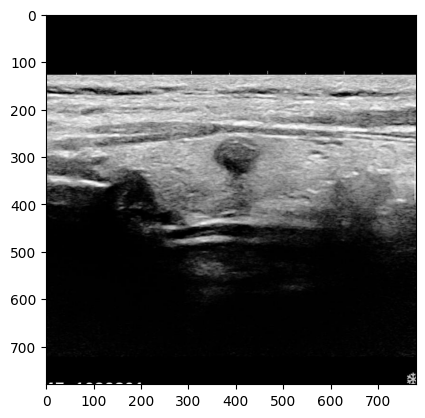

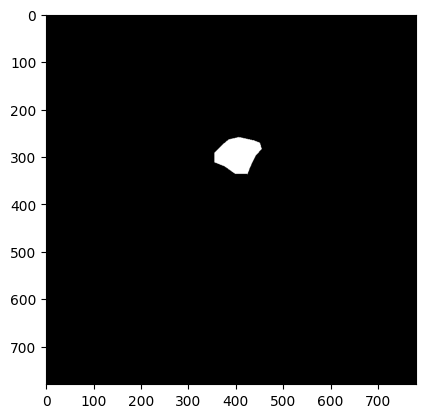

In [40]:
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(mask)

print(mask.shape, image.shape)

In [11]:
#images importation

im1 = crop(img_as_ubyte( skio.imread('data/eclat.jpg', as_gray = True)))
im2 = crop(img_as_ubyte( skio.imread('data/smock.jpg', as_gray = True)))
im3 = crop(img_as_ubyte( skio.imread('data/lune.jpg', as_gray = True)))
im4 = crop(img_as_ubyte( skio.imread('data/cerveau.tif', as_gray = True)))
im5 = crop(img_as_ubyte( skio.imread('data/textured-triangle.png', as_gray = True)))

<Figure size 640x480 with 0 Axes>

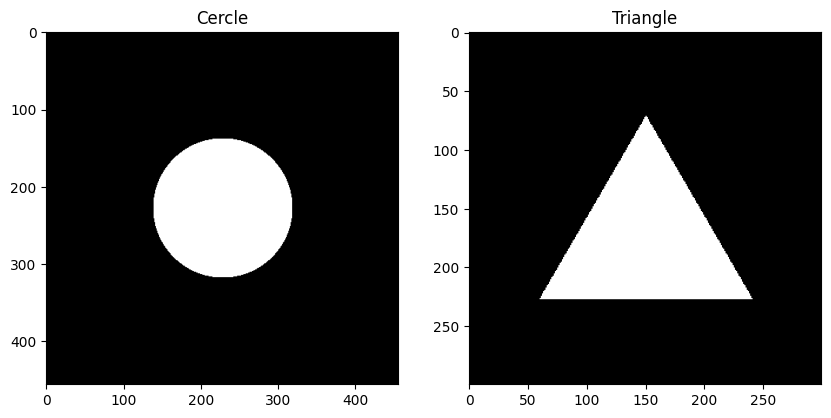

In [12]:
#masks initialisation
plt.set_cmap("gray")
mask_cir = circular_mask(im3,90)
mask_triangle = triangle_mask(im5, 180)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(mask_cir)
axes[0].set_title('Cercle') 
axes[1].imshow(mask_triangle)
axes[1].set_title('Triangle') 
plt.show()

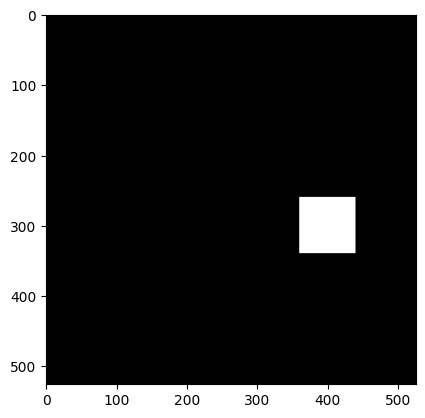

In [13]:
brain_mask = np.zeros(im4.shape)
O = (300,400)

brain_mask[(O[0]-40):(O[0]+40), (O[1]-40) : (O[1]+40)] = 1

plt.imshow(brain_mask)

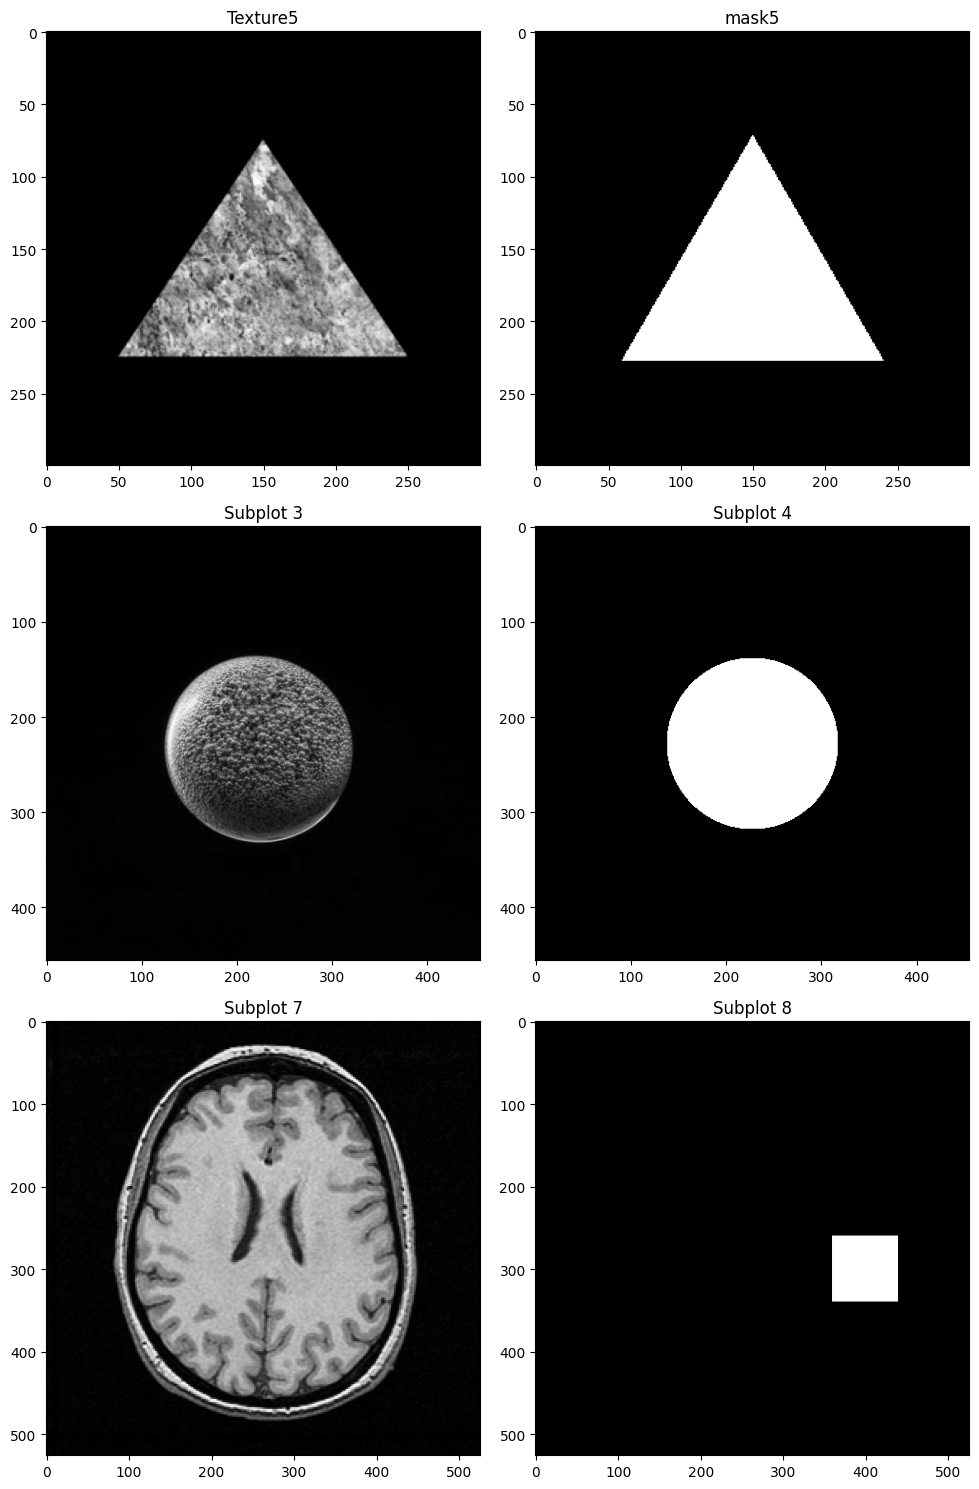

In [14]:
fig, axs = plt.subplots(3, 2,figsize=(10, 15))

# Now, you can plot your data on each subplot
axs[0, 0].imshow(im5, cmap = 'gray')
axs[0, 0].set_title('Texture5')
axs[0, 1].imshow(mask_triangle, cmap = 'gray')
axs[0, 1].set_title('mask5')
axs[1, 0].imshow(im3, cmap = 'gray')
axs[1, 0].set_title('Subplot 3')
axs[1, 1].imshow(mask_cir, cmap = 'gray')
axs[1, 1].set_title('Subplot 4')
axs[2, 0].imshow(im4, cmap = 'gray')
axs[2, 0].set_title('Subplot 7')
axs[2, 1].imshow(brain_mask, cmap = 'gray')
axs[2, 1].set_title('Subplot 8')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

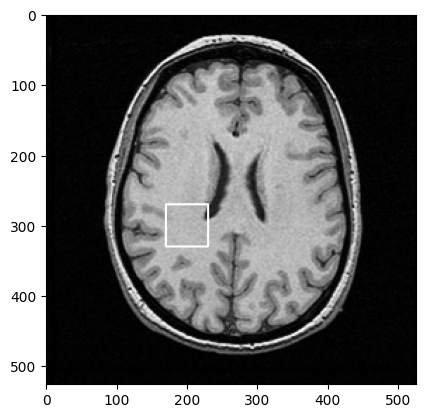

In [15]:
O = (200, 300)
top_left = (O[0] + 30, O[1] + 30)
bottom_right = (O[0] - 30, O[1] - 30)

# Créer une image noire de la même taille que im4
image_noire = np.zeros(im4.shape, dtype=np.uint8)
im=im4.copy()
# Dessiner le contour du carré en jaune sur l'image noire
cv2.rectangle(im, top_left, bottom_right, (255, 255, 255), thickness=2)
plt.imshow(im)


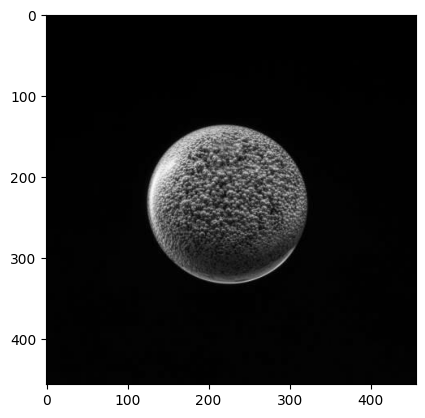

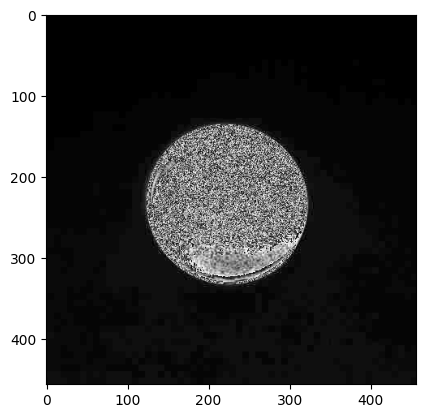

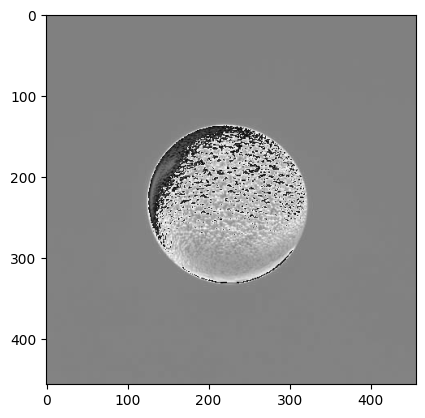

In [16]:
plt.figure()
plt.imshow(im3, cmap="gray")
adjusted_image_array = (im3 - 128) * 5 + 128
plt.figure()
plt.imshow(adjusted_image_array, cmap="gray")
plt.figure()
plt.imshow((im3 - 128) * 1.2 + 128, cmap="gray")

# Deploy the Feature Extractor (GLCM feature)

In [17]:
# Transform image and mask to the supported format
im1_ITK, mask1_ITK  = sitk.GetImageFromArray(im5), sitk.GetImageFromArray(mask_triangle)
im2_ITK, mask2_ITK  = sitk.GetImageFromArray(im3), sitk.GetImageFromArray(mask_cir)
im3_ITK, mask3_ITK  = sitk.GetImageFromArray(im4), sitk.GetImageFromArray(brain_mask)
#end

In [18]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im2_ITK, mask2_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [19]:
features = np.array(list(result.values()))
args = list(result.keys())

In [20]:
im_noised_list = [noise(im3, 5).astype(np.int32)        for i in range(50)]
im_noised_list +=[noise(im3,br = 20).astype(np.int32)   for i in range(50)]
im_noised_list +=[noise(im3,br = 50).astype(np.int32)   for i in range(50)]


## Etude par erreur relatif:

- On plotera l'erreur relatif entre la mesure initilae de feature avec la mesure erroné introduit par le bruit : 

$$\boxed{\textcolor{red}{e_{rr} = \frac{(f_{réelle} - f_{mesuré})^2}{f_{réelle}^2}}}$$

- **Noise stability for textured moon**

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


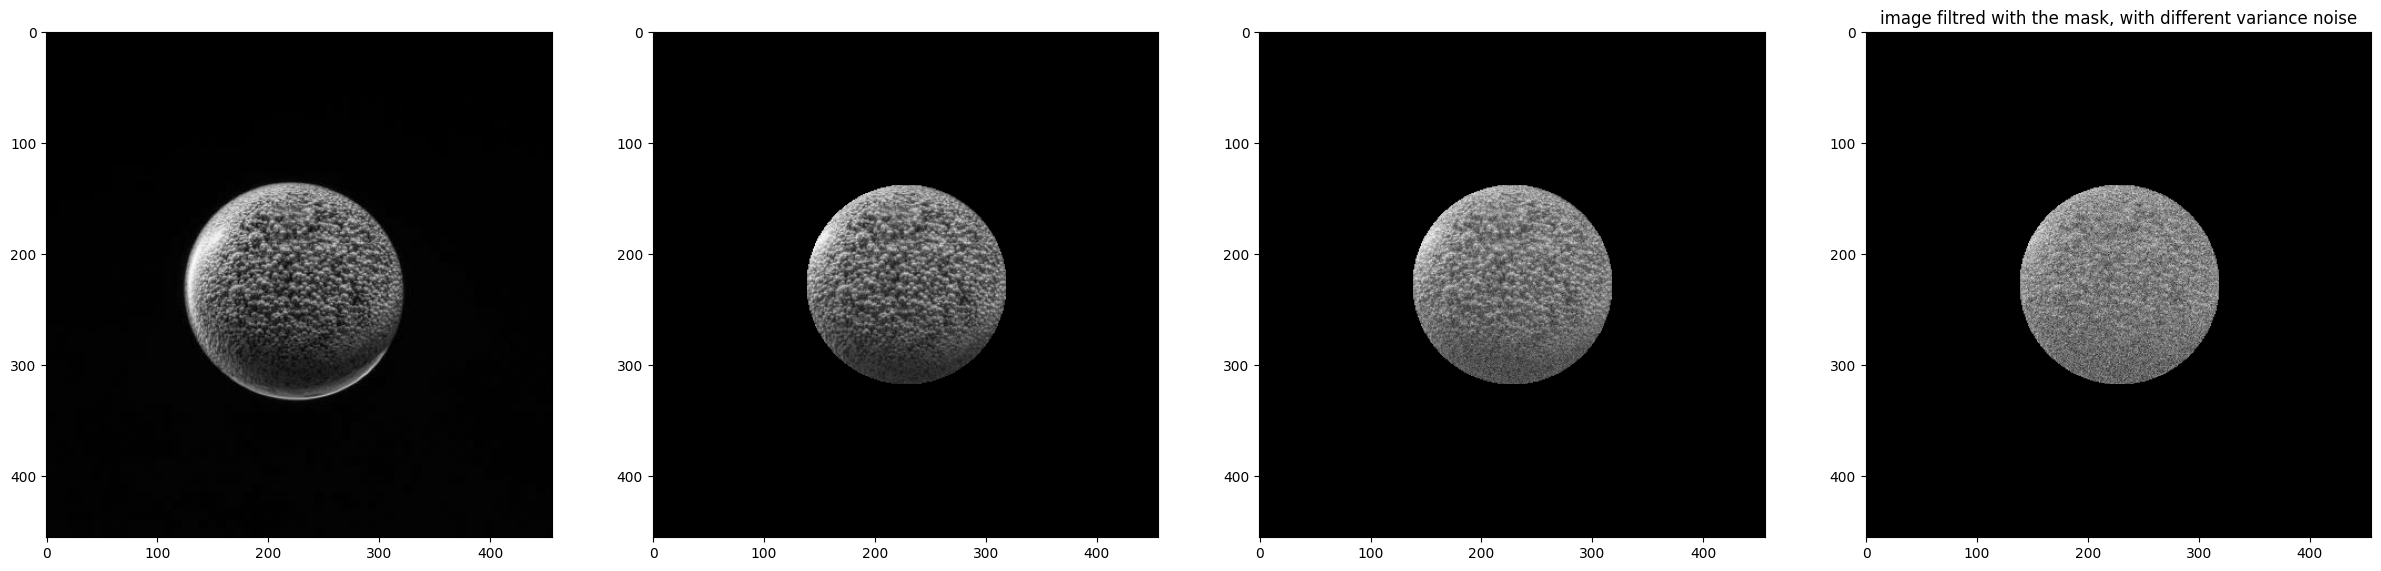

In [21]:

glcmFeatures = glcm.RadiomicsGLCM(im2_ITK, mask2_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list = [noise(im3, 5).astype(np.int32)        for i in range(50)]
im_noised_list +=[noise(im3,br = 20).astype(np.int32)   for i in range(50)]
im_noised_list +=[noise(im3,br = 50).astype(np.int32)   for i in range(50)]

fig, axs = plt.subplots(1,4,figsize=(30, 30))
plt.title("image filtred with the mask, with different variance noise")
im_noised_5 = noise(im3,br = 5).astype(np.int32)
im_noised_20 = noise(im3,br = 20).astype(np.int32)
im_noised_50 = noise(im3,br = 50).astype(np.int32)

# Now, you can plot your data on each subplot
axs[0].imshow(im3, cmap = 'gray')
axs[1].imshow( (im_noised_5 - np.min(im_noised_5)) * mask_cir , cmap = 'gray')
axs[2].imshow( (im_noised_20 - np.min(im_noised_20)) * mask_cir, cmap = 'gray')
axs[3].imshow( (im_noised_50 - np.min(im_noised_50)) * mask_cir, cmap = 'gray')

plt.title("image filtred with the mask, with different variance noise")
plt.show()

In [22]:
features_noised = [features]

for i in range(len(im_noised_list)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list[i])
  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask2_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append(np.array(list(result.values())))

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [23]:
noise_err_1 = np.array([((features_noised[i] - features)**2)/features**2 for i in range(150)])
noise_MSE_1 = [mse(noise_err_1[:,i], 0) for i in range(24)]

- **Noise stabity for The textured triangle**

In [24]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list = [noise(im5, 10).astype(np.int32)     for i in range(50)]
im_noised_list +=[noise(im5,br = 50).astype(np.int32)  for i in range(50)]
im_noised_list += [noise(im5,br = 100).astype(np.int32)  for i in range(50)]

features_noised = [features]

for i in range(len(im_noised_list)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

noise_err_3 = np.array([((features_noised[i] - features)**2)/features**2 for i in range(150)])
noise_MSE_3 = [mse(noise_err_3[:,i], 0) for i in range(24)]

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

- **Noise stability for brain image**

In [25]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im3_ITK, mask3_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list4 = [noise(im4, 10).astype(np.int32)  for i in range(50)]
im_noised_list4 +=[noise(im4,br = 50).astype(np.int32)  for i in range(50)]
im_noised_list4 += [noise(im4,br = 100).astype(np.int32)  for i in range(50)]

features_noised = [features]

for i in range(len(im_noised_list4)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list4[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask3_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

noise_err_4 = np.array([((features_noised[i] - features)**2)/features**2 for i in range(150)])
noise_MSE_4 = [mse(noise_err_4[:,i], 0) for i in range(24)]


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

- **Visualisation des résultats**

- $\textcolor{blue}{Erreur\ relative}$

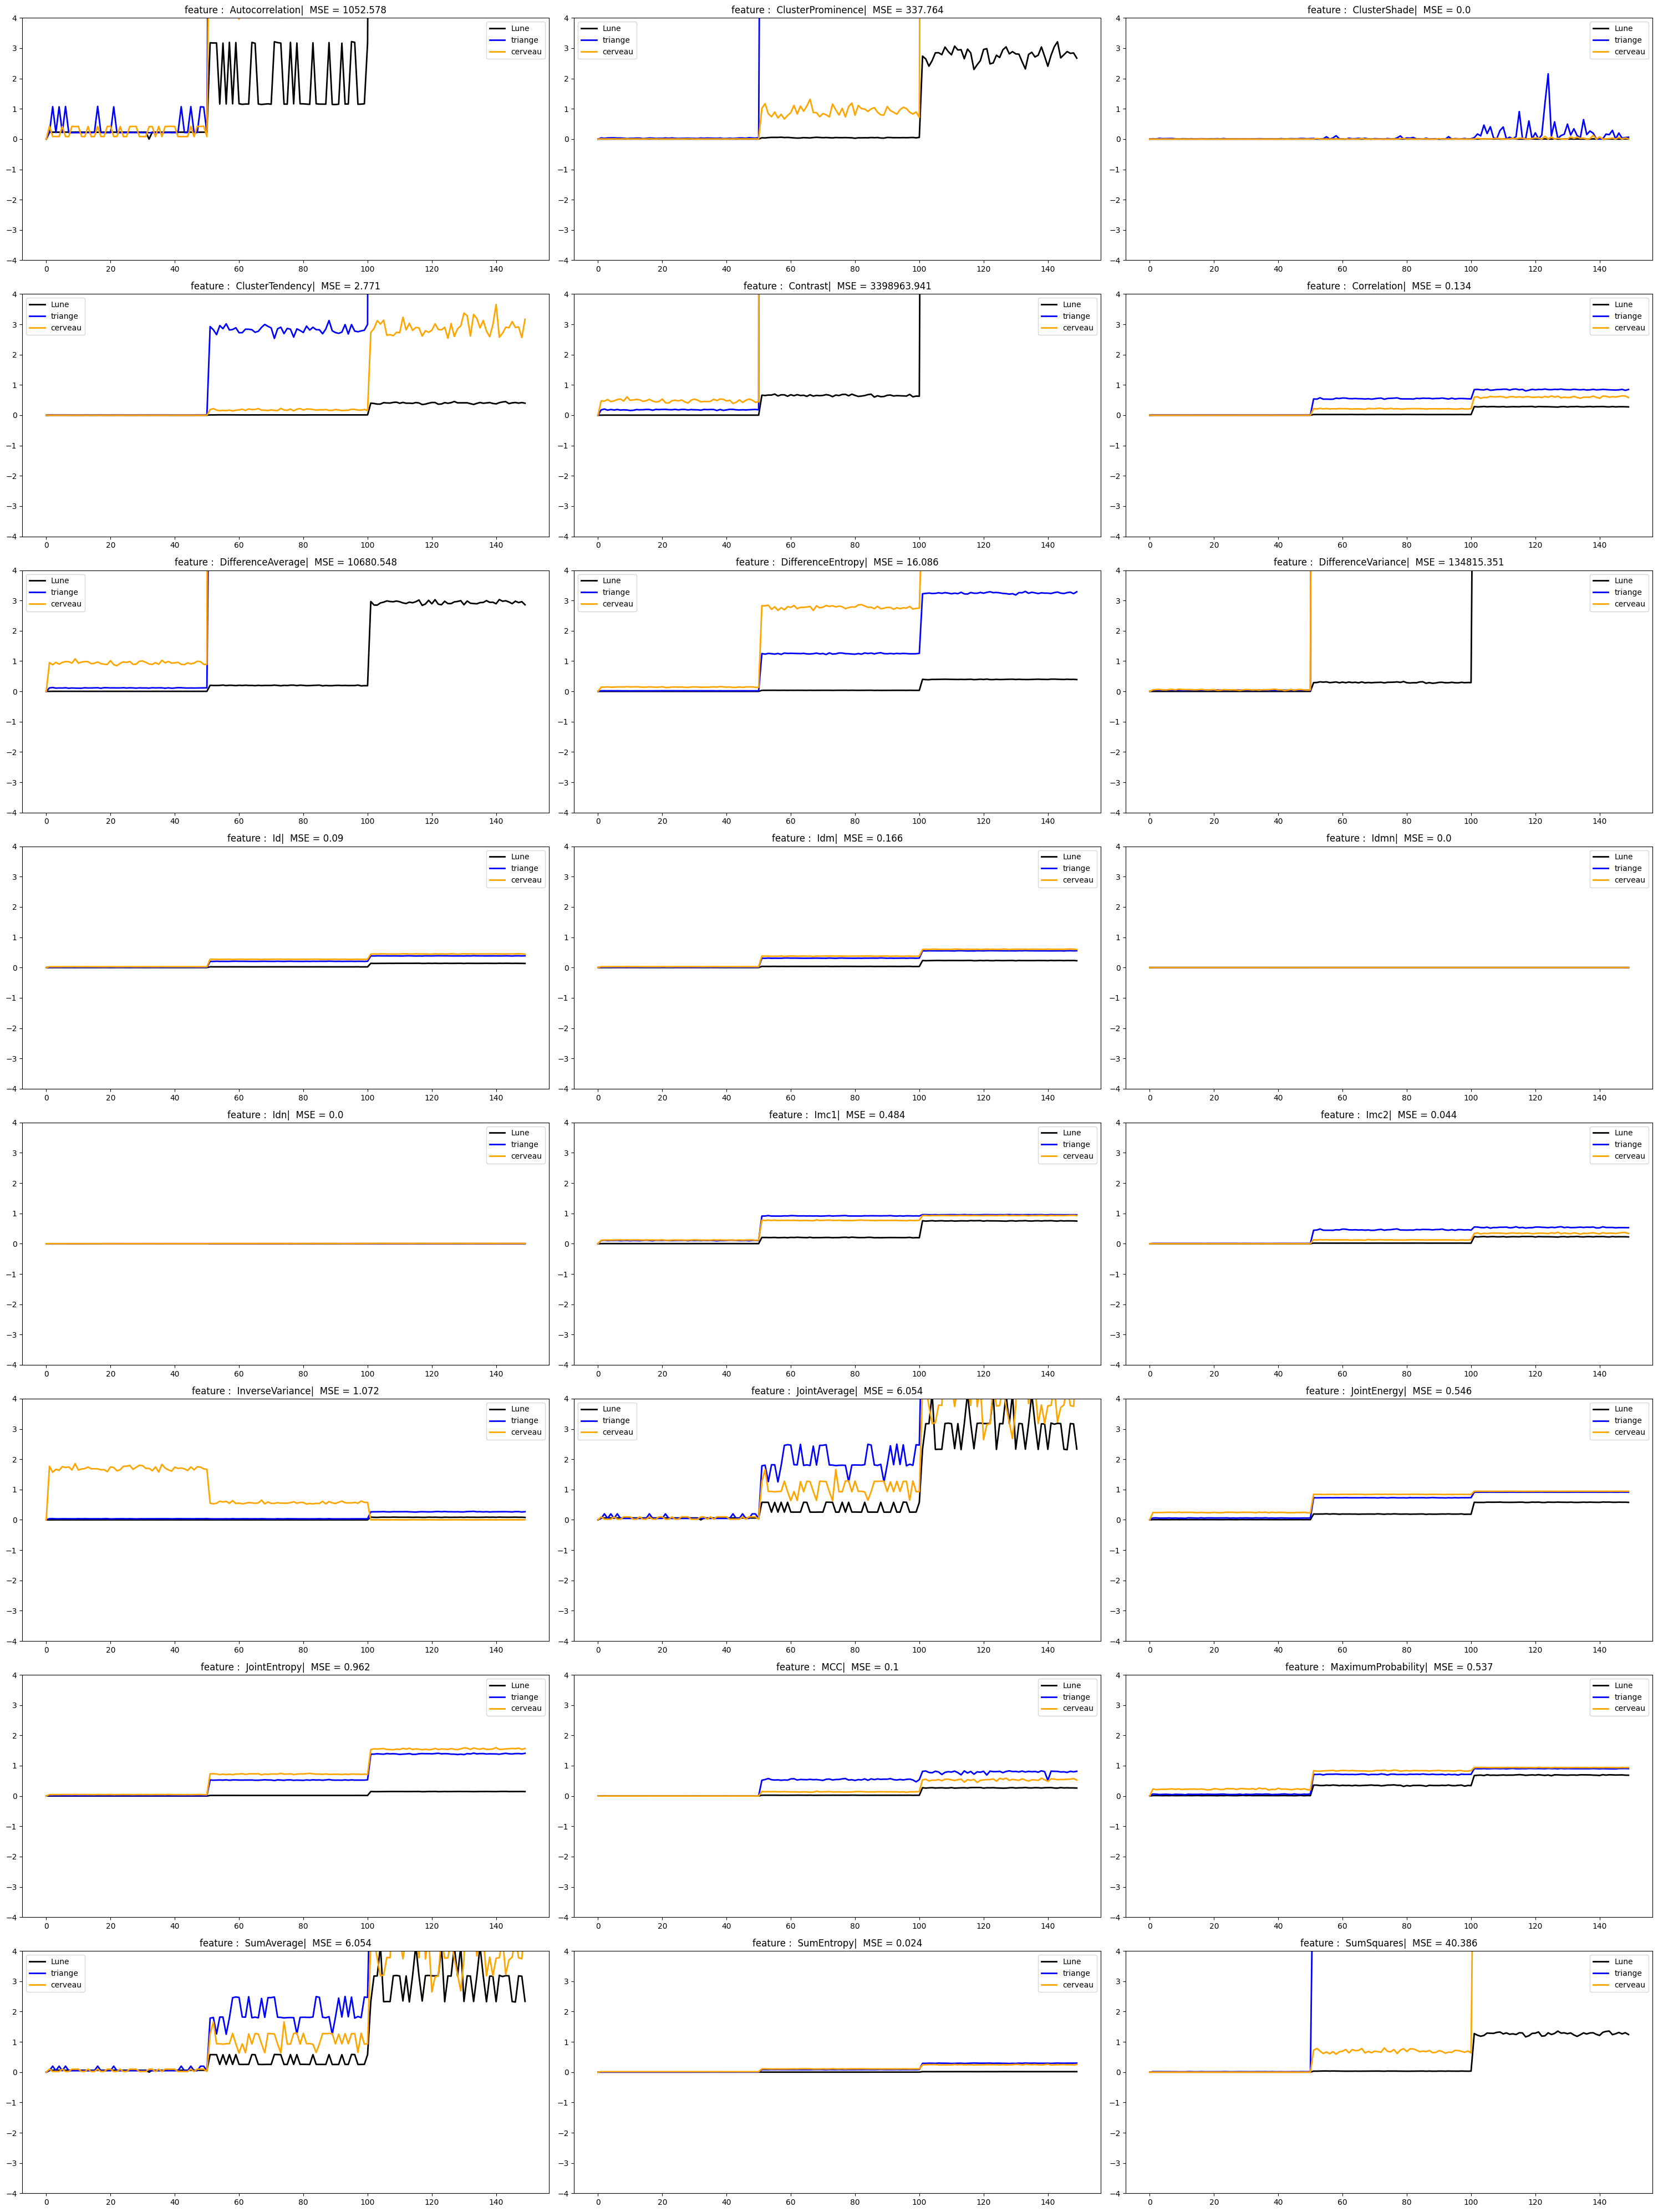

In [26]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))

for i in range(8):
    for j in range(3):
        axs[i, j].plot(noise_err_1[:,3*i+j], linewidth=2, color="black", label="Lune")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(noise_err_3[:,3*i+j], linewidth=2, color="blue", label="triange")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(noise_err_4[:,3*i+j], linewidth=2, color = "orange", label="cerveau")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_4[3*i+j], 3) ))
        axs[i, j].legend()


for ax in axs.flat:
    ax.set_ylim(-4, 4)


# Adjust spacing between subplots
plt.tight_layout()
# Show the figure
plt.show()

- $\textcolor{blue}{MSE}$


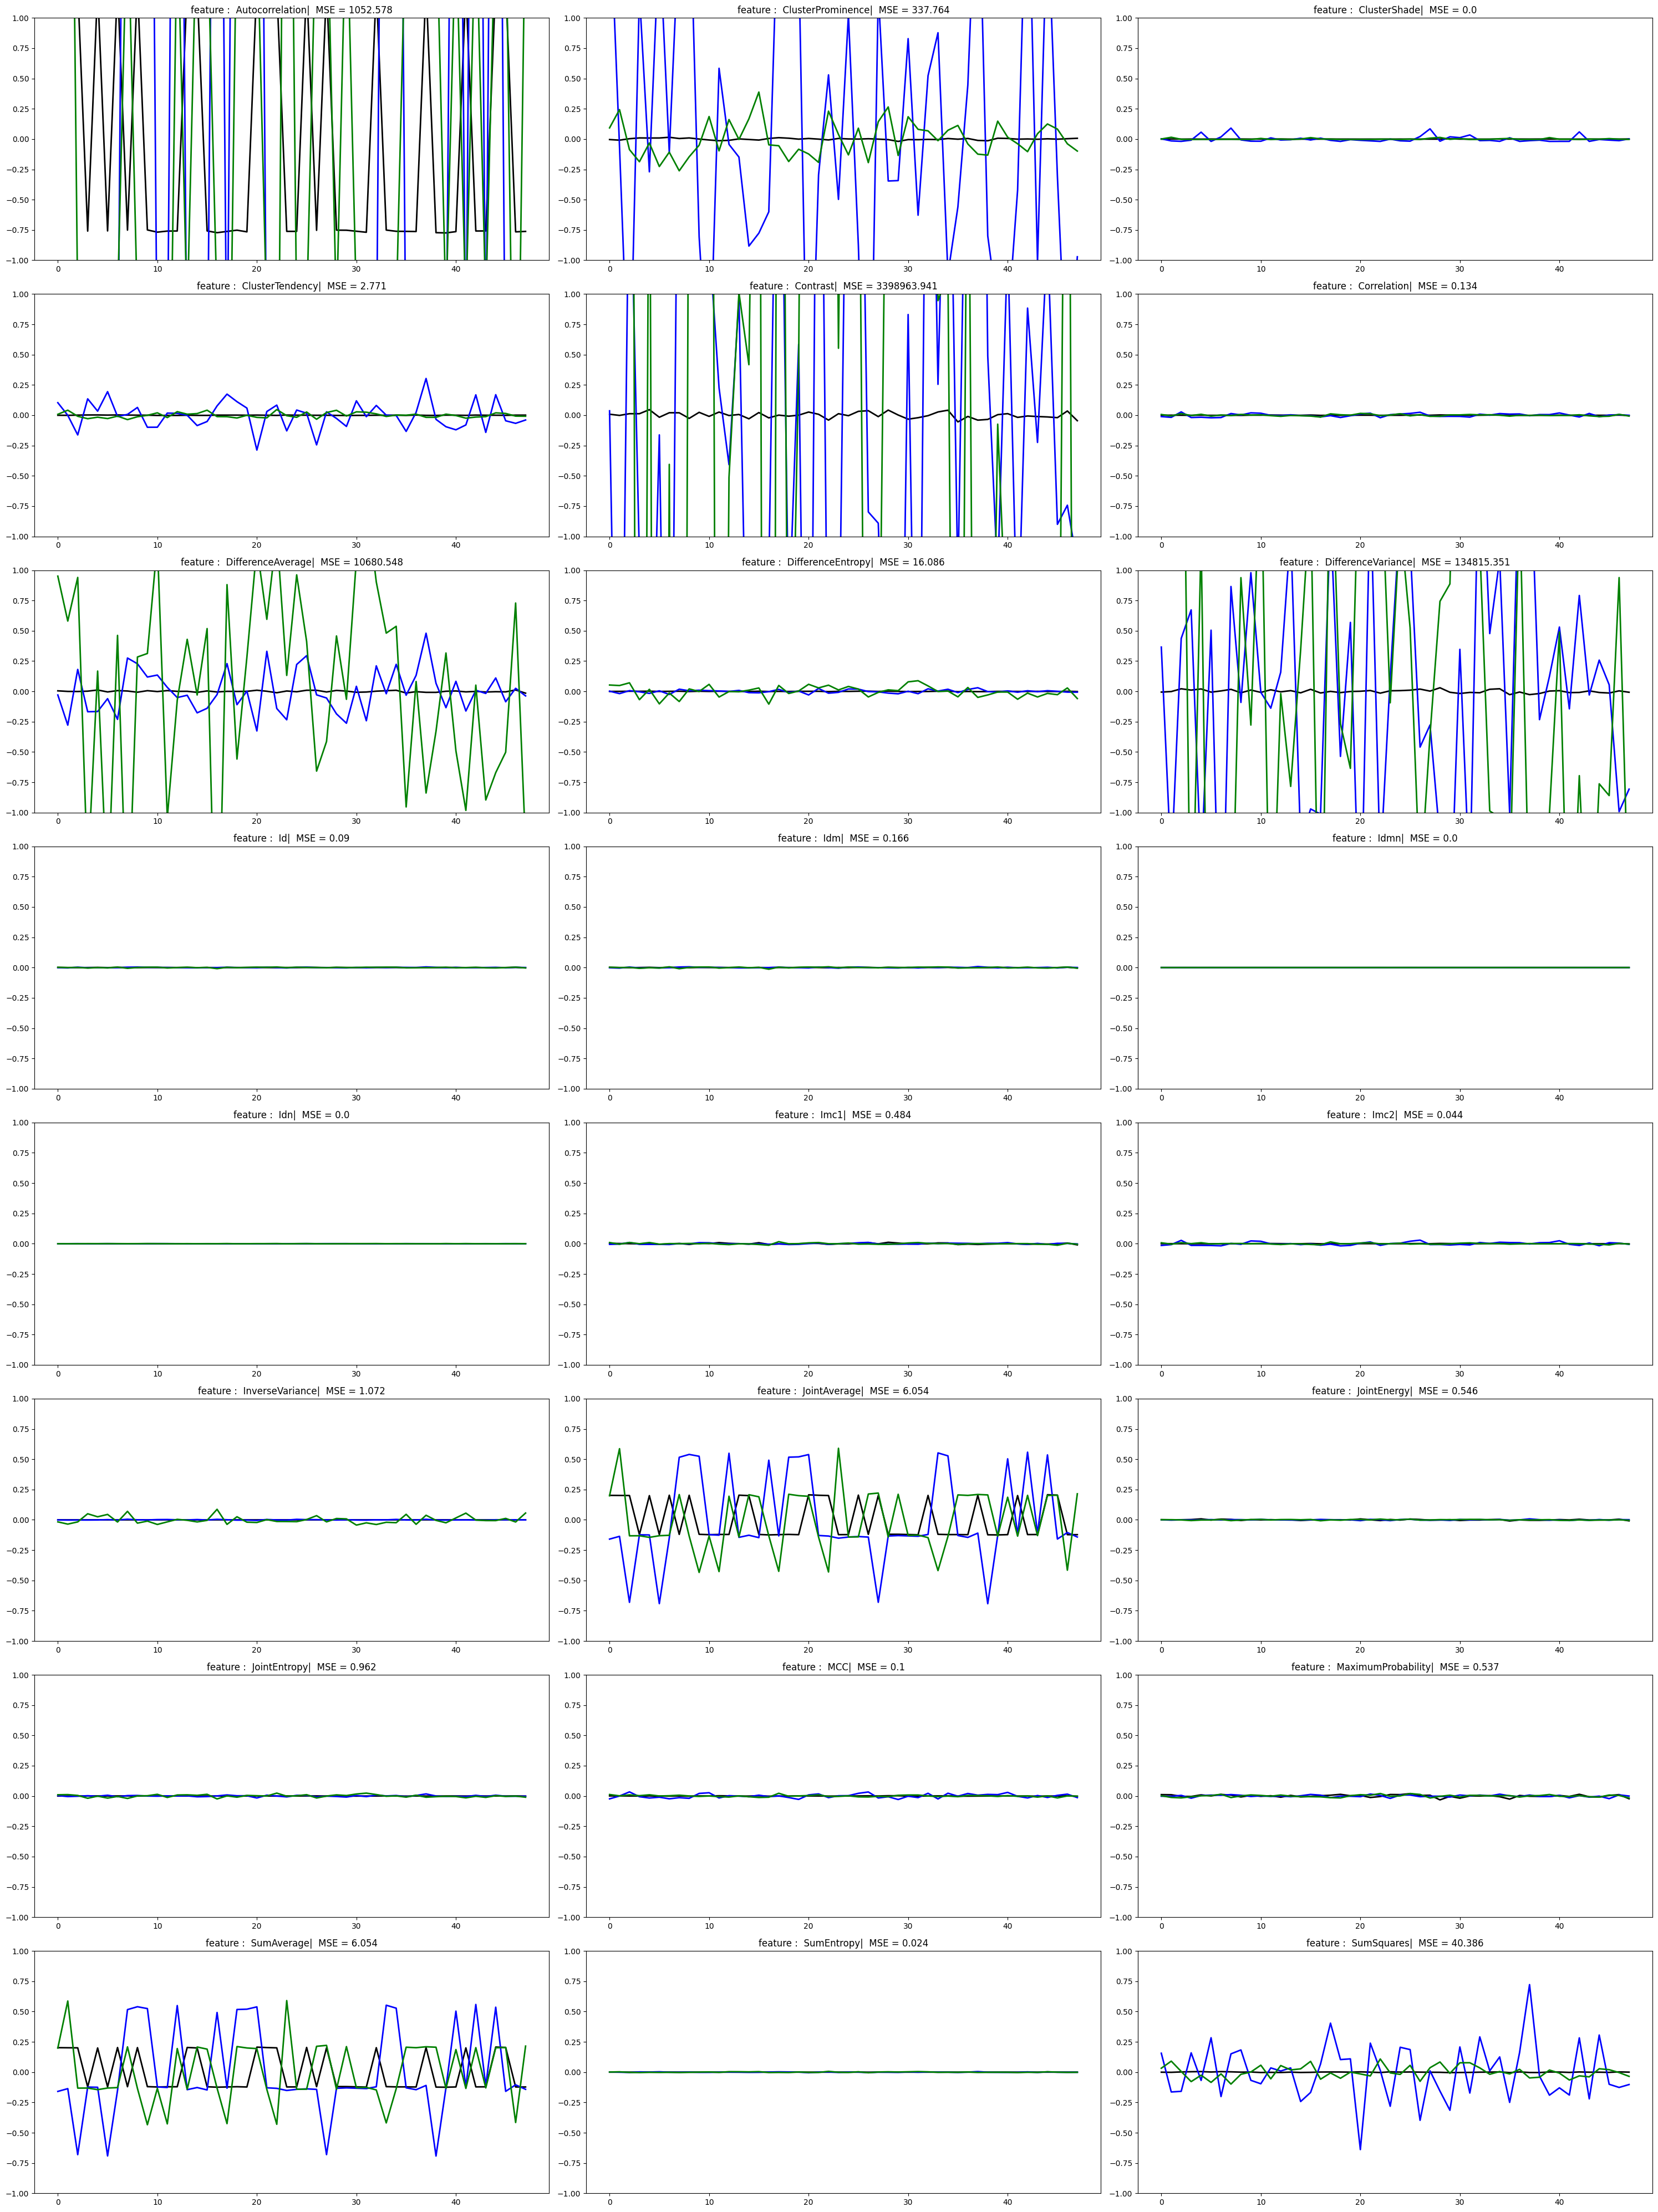

In [27]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot( (noise_err_1[51:99,3*i+j] - np.mean(noise_err_1[51:99,3*i+j]) )  , linewidth=2, color="black")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(  (noise_err_3[51:99,3*i+j] - np.mean(noise_err_3[51:99,3*i+j])  ),  linewidth=2, color="blue")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(  (noise_err_4[51:99,3*i+j] - np.mean(noise_err_4[51:99,3*i+j]) ), linewidth=2, color="green")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
   ax.set_ylim(-1, 1)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Blur Stability

In [28]:
im_flou1 = flou(im3, kernel_size=3)
im_flou2 = flou(im3, kernel_size=5)

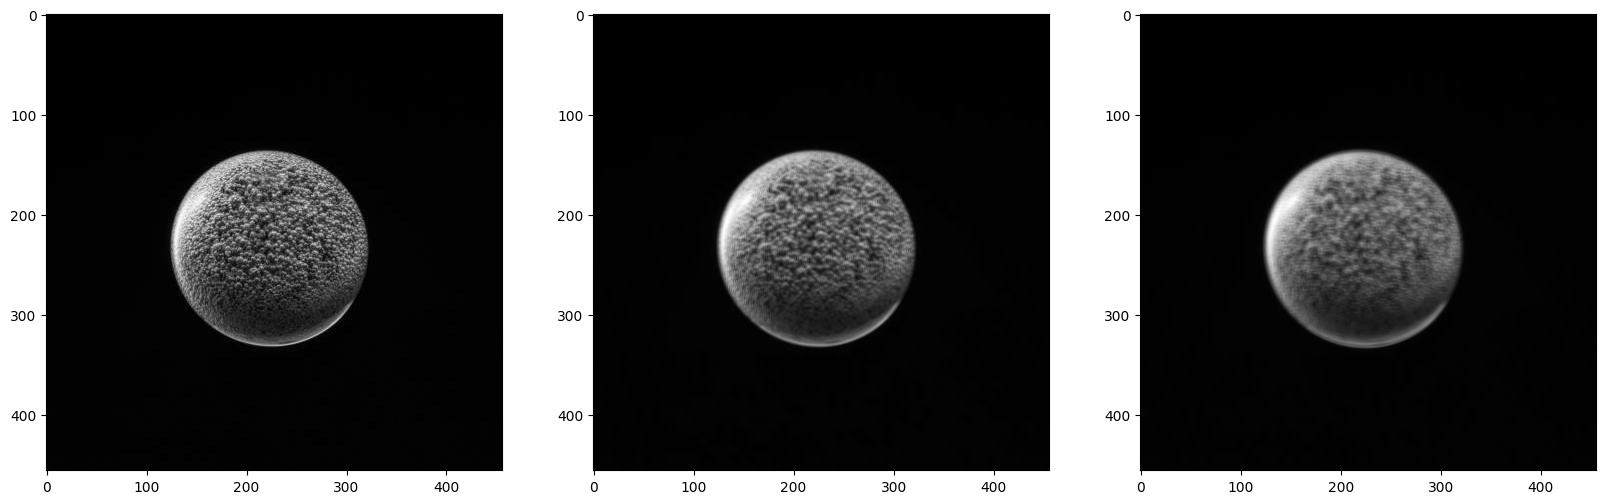

In [29]:
fig, axs = plt.subplots(1,3,figsize=(20, 20))

# Now, you can plot your data on each subplot
axs[0].imshow(im3, cmap = 'gray')

axs[1].imshow(im_flou1, cmap = 'gray')

axs[2].imshow(im_flou2, cmap = 'gray')



- **Stabilité par Flou pour l'image lune:**

In [30]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im2_ITK, mask2_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im3,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im3,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask2_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_1 = np.array([((features_noised[i] - features)**2)/features**2 for i in range(100)])
blurr_MSE_1   = [mse(blurr_error_1[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

- **Stabilité par Flou pour l'image cerveau:**

In [31]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im3_ITK, mask3_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im4,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im4,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask3_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_3 = np.array([((features_noised[i] - features)**2)/features**2 for i in range(100)])
blurr_MSE_3   = [mse(blurr_error_3[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

- **Stabilité par Flou pour l'image pyramide:**

In [32]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im5,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im5,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_4 = np.array([((features_noised[i] - features)**2)/features**2 for i in range(100)])
blurr_MSE_4   = [mse(blurr_error_4[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

- **Visualisation des resultats:**

- $\textcolor{blue}{Erreur\ relative}$

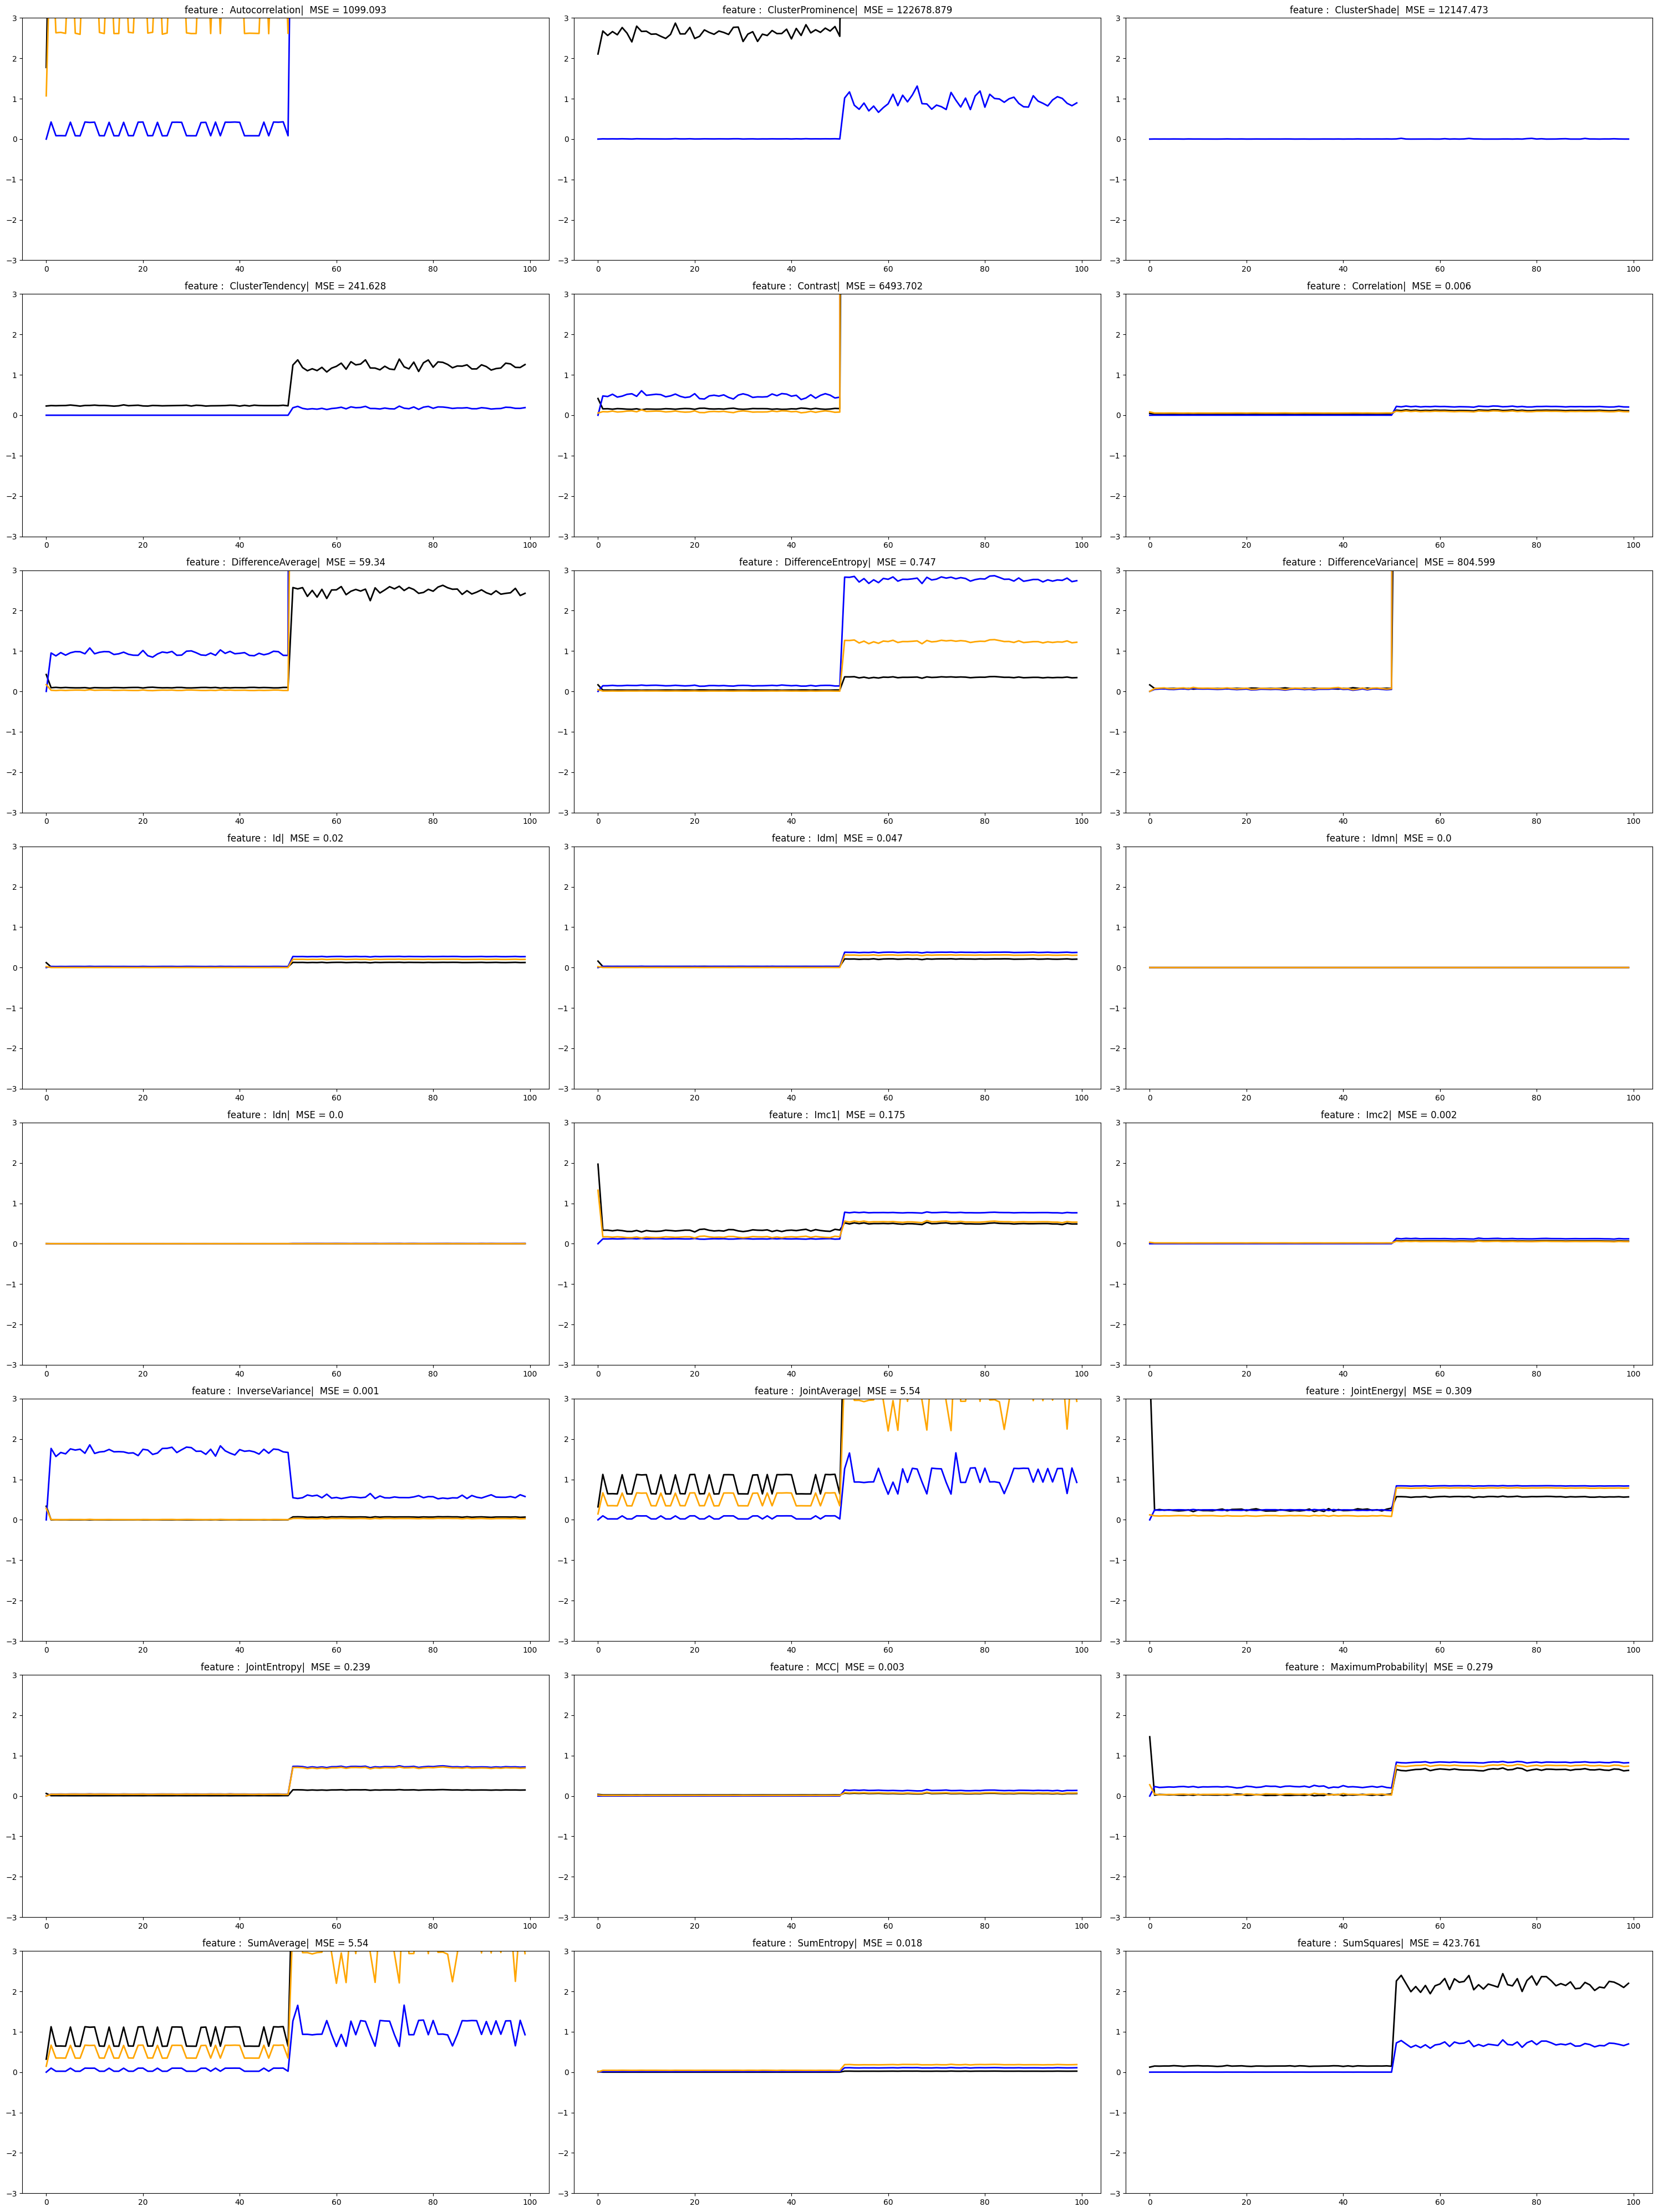

In [33]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot(blurr_error_1[:,3*i+j], linewidth=2, color="black")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(blurr_error_3[:,3*i+j], linewidth=2, color="blue")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(blurr_error_4[:,3*i+j], linewidth=2, color="orange")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
    ax.set_ylim(-3, 3)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

- $\textcolor{blue}{MSE}$

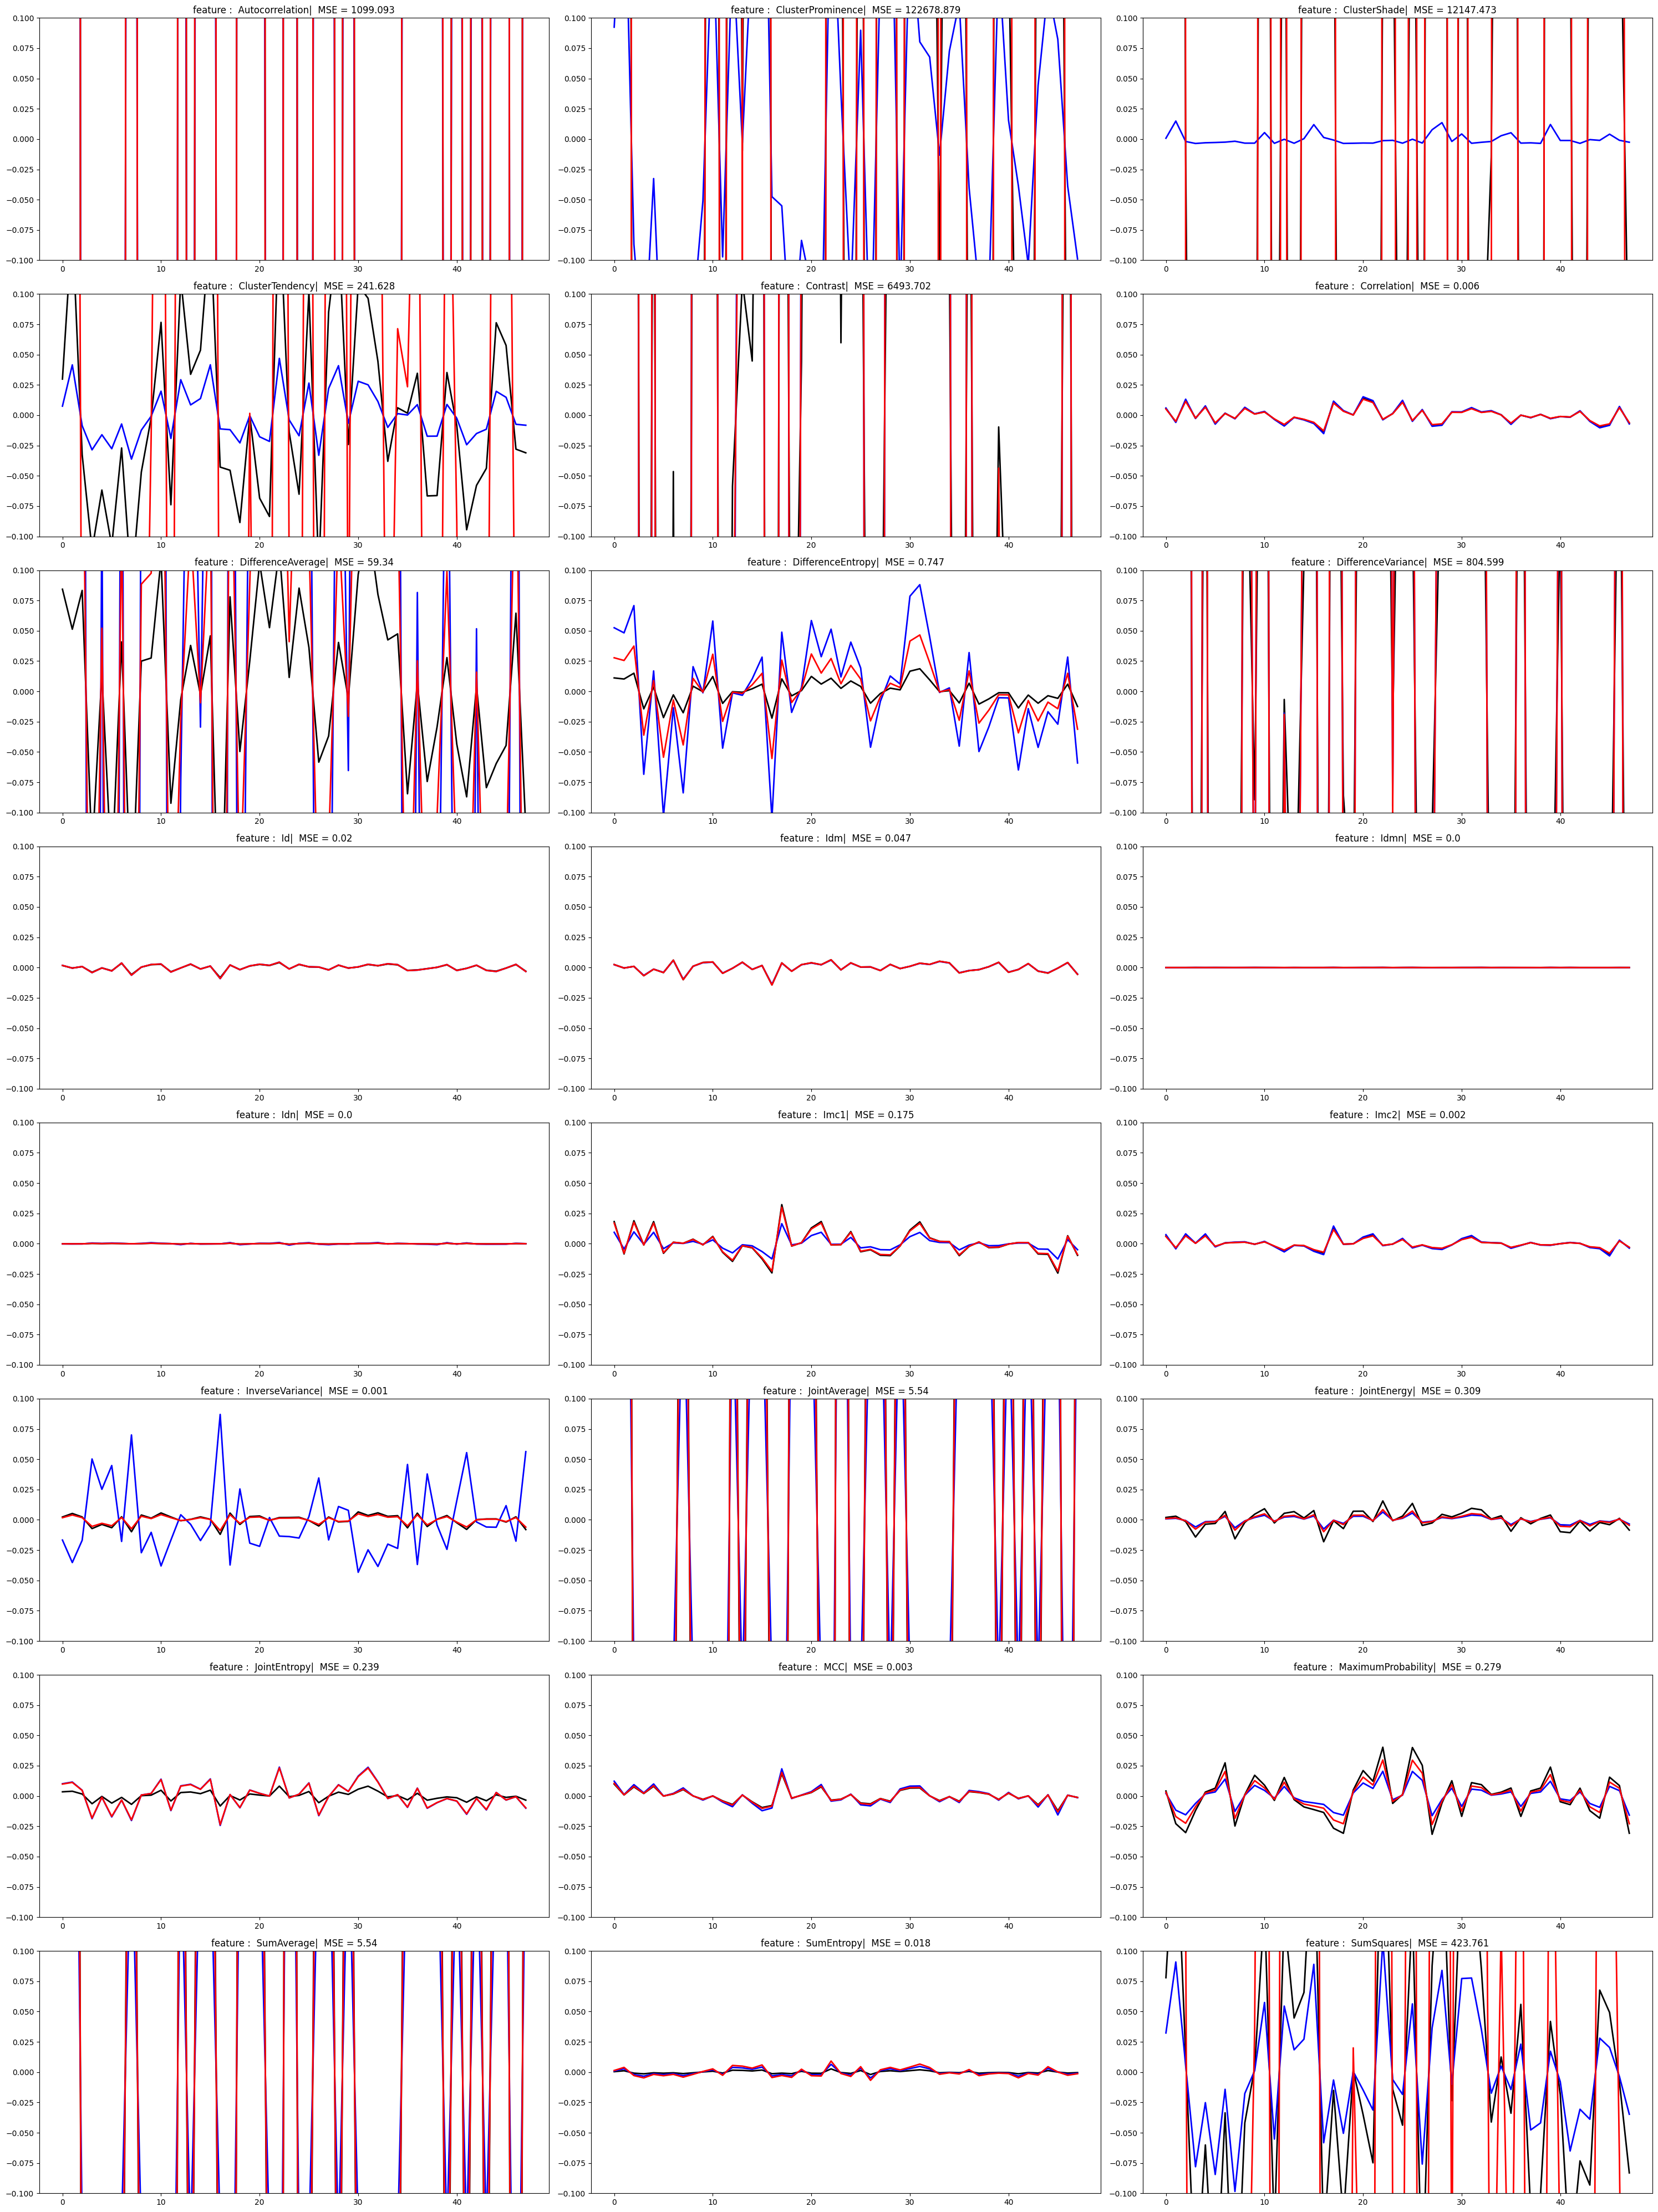

In [34]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot( (blurr_error_1[51:99,3*i+j] - np.mean(blurr_error_1[51:99,3*i+j]) )  , linewidth=2, color="black")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(  (blurr_error_3[51:99,3*i+j] - np.mean(blurr_error_3[51:99,3*i+j])  ),  linewidth=2, color="blue")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(  (blurr_error_4[51:99,3*i+j] - np.mean(blurr_error_4[51:99,3*i+j]) ), linewidth=2, color="red")
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
   ax.set_ylim(-0.1, 0.1)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
from warnings import warn

def get_jpegs(export_path: str, data_type: str):
    '''Convert each slice of nnrd containing ROI to JPEG image. Quick and convenient way to check your ROIs after conversion.

    Arguments:
        export_path: Path to the folder where the JPEGs will be generated.
        data_type: Type of data, e.g., 'nrrd'.
    '''
    if data_type == 'nrrd':
        # Loop through patients and process data
        for pat, path in tqdm(desc='Patients processed'):
            try:
                temp_data = sitk.ReadImage(path[0])
                temp_mask = sitk.ReadImage(path[1])
                temp_image_array = sitk.GetArrayFromImage(temp_data)
                temp_mask_array = sitk.GetArrayFromImage(temp_mask)

                directory = os.path.join(export_path, 'images_quick_check', pat, path[1][:-5].split(os.sep)[-1])
                z_dist = np.sum(temp_mask_array, axis=(1, 2))
                z_ind = np.where(z_dist != 0)[0]

                for j in z_ind:
                    if not os.path.exists(directory):
                        os.makedirs(directory)
                    temp_image_array[j, 0, 0] = 1
                    temp_mask_array[j, 0, 0] = 1
                    plt.figure(figsize=(20, 20))
                    plt.subplot(121)
                    plt.imshow(temp_image_array[j, ...], cmap='bone')
                    plt.subplot(122)
                    plt.imshow(temp_image_array[j, ...], cmap='bone')
                    plt.contour(temp_mask_array[j, ...], colors='red', linewidths=2)
                    plt.savefig(os.path.join(directory, 'slice #%d' % j), bbox_inches='tight')
                    plt.close()
            except Exception:
                warn('Something wrong with %s' % pat)
    else:
        raise TypeError('The toolbox should be initialized with data_type = "nrrd"')

    

In [57]:
import SimpleITK as sitk
from radiomics import featureextractor

# Load sample image and mask (replace 'image.nii.gz' and 'mask.nii.gz' with your file paths)
image_path = 'IMA201_Medical_images/Brain_MRI_BRATS_TCIA13_633/Brats18_TCIA13_633_1_flair.nii'
mask_path = 'IMA201_Medical_images/Brain_MRI_BRATS_TCIA13_633/Brats18_TCIA13_633_1_seg.nii'

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

# Initialize the feature extractor with default settings
extractor = featureextractor.RadiomicsFeatureExtractor()

# You can modify settings directly without a YAML file
extractor.settings['binWidth'] = 25  # Example modification of a setting

# Extract features
all_result = extractor.execute(image, mask)


#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(image, mask)
glcmFeatures.enableAllFeatures()
glcm_result = glcmFeatures.execute()


features = np.array(list(glcm_result.values()))
args = list(glcm_result.keys())

# Access the extracted features
for feature_name in all_result.keys():
    print(f"Feature '{feature_name}' has value {all_result[feature_name]}")

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Feature 'diagnostics_Versions_PyRadiomics' has value v3.0.1
Feature 'diagnostics_Versions_Numpy' has value 1.24.3
Feature 'diagnostics_Versions_SimpleITK' has value 2.3.0
Feature 'diagnostics_Versions_PyWavelet' has value 1.4.1
Feature 'diagnostics_Versions_Python' has value 3.10.11
Feature 'diagnostics_Configuration_Settings' has value {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25}
Feature 'diagnostics_Configuration_EnabledImageTypes' has value {'Original': {}}
Feature 'diagnostics_Image-original_Hash' has value afdc49dee97ff13078c9713db3bf4057a6af4c2a
Feature 'diagnostics_Image-original_Dimensionality' has value 3D
Feature 'diagnostics_Image-original_Spacing' has value (1.0, 1.0, 1.0)
F

In [59]:
# Access the extracted features
for feature_name in glcm_result.keys():
    print(f"Feature '{feature_name}' = {glcm_result[feature_name]}")

Feature 'Autocorrelation' = 183.26255060424944
Feature 'ClusterProminence' = 527.0577168649754
Feature 'ClusterShade' = -18.37331375686744
Feature 'ClusterTendency' = 12.621960395967612
Feature 'Contrast' = 0.7685498236356243
Feature 'Correlation' = 0.8850363413536274
Feature 'DifferenceAverage' = 0.5691855581303064
Feature 'DifferenceEntropy' = 1.3209540760665557
Feature 'DifferenceVariance' = 0.4327819940733043
Feature 'Id' = 0.7446400883760015
Feature 'Idm' = 0.7349510682344444
Feature 'Idmn' = 0.9978915235049451
Feature 'Idn' = 0.9720037063409955
Feature 'Imc1' = -0.4006017349634578
Feature 'Imc2' = 0.9451488985508322
Feature 'InverseVariance' = 0.42972954019292575
Feature 'JointAverage' = 13.427546122105953
Feature 'JointEnergy' = 0.05883471872393164
Feature 'JointEntropy' = 4.6247353418059
Feature 'MCC' = 0.895488795743055
Feature 'MaximumProbability' = 0.11613336870354746
Feature 'SumAverage' = 26.855092244211903
Feature 'SumEntropy' = 3.819011264207986
Feature 'SumSquares' = 3.

In [60]:
import SimpleITK as sitk
from radiomics import featureextractor

# Load sample image and mask (replace 'image.nii.gz' and 'mask.nii.gz' with your file paths)
mask_path = 'patient0001_2CH_ED_gt.nii'
image_path = 'patient0001_2CH_ED.nii'

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

# Initialize the feature extractor with default settings
extractor = featureextractor.RadiomicsFeatureExtractor()

# You can modify settings directly without a YAML file
extractor.settings['binWidth'] = 25  # Example modification of a setting

# Extract features
all_result = extractor.execute(image, mask)


#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(image, mask)
glcmFeatures.enableAllFeatures()
glcm_result = glcmFeatures.execute()


features = np.array(list(glcm_result.values()))
args = list(glcm_result.keys())

# Access the extracted features
for feature_name in all_result.keys():
    print(f"Feature '{feature_name}' has value {all_result[feature_name]}")

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Feature 'diagnostics_Versions_PyRadiomics' has value v3.0.1
Feature 'diagnostics_Versions_Numpy' has value 1.24.3
Feature 'diagnostics_Versions_SimpleITK' has value 2.3.0
Feature 'diagnostics_Versions_PyWavelet' has value 1.4.1
Feature 'diagnostics_Versions_Python' has value 3.10.11
Feature 'diagnostics_Configuration_Settings' has value {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25}
Feature 'diagnostics_Configuration_EnabledImageTypes' has value {'Original': {}}
Feature 'diagnostics_Image-original_Hash' has value 2b073d42fcd735ed928efc76892eb2cb79821f4e
Feature 'diagnostics_Image-original_Dimensionality' has value 2D
Feature 'diagnostics_Image-original_Spacing' has value (0.30799999833106

In [61]:
# Access the extracted features
for feature_name in glcm_result.keys():
    print(f"Feature '{feature_name}' = {glcm_result[feature_name]}")

Feature 'Autocorrelation' = 22.67861358524934
Feature 'ClusterProminence' = 519.3318607392092
Feature 'ClusterShade' = 33.363587913244324
Feature 'ClusterTendency' = 10.496983069959517
Feature 'Contrast' = 0.33543750328839356
Feature 'Correlation' = 0.9380178575679873
Feature 'DifferenceAverage' = 0.3226360231892395
Feature 'DifferenceEntropy' = 0.9328722060795749
Feature 'DifferenceVariance' = 0.22771484225284663
Feature 'Id' = 0.8407870907852195
Feature 'Idm' = 0.8399621364152958
Feature 'Idmn' = 0.9972557971347304
Feature 'Idn' = 0.973195412563034
Feature 'Imc1' = -0.5427080202889166
Feature 'Imc2' = 0.9677975522838682
Feature 'InverseVariance' = 0.3117036835600734
Feature 'JointAverage' = 4.4875622387394944
Feature 'JointEnergy' = 0.11270032526379876
Feature 'JointEntropy' = 3.753040991138569
Feature 'MCC' = 0.9612879315731393
Feature 'MaximumProbability' = 0.22094050845555407
Feature 'SumAverage' = 8.975124477478989
Feature 'SumEntropy' = 3.392205707483915
Feature 'SumSquares' = 2